In [2]:
import numpy as np
import xarray as xr
import salishsea_tools.river_202108 as rivers
import pandas as pd

In [5]:
def make_ts_arr(jdepth, data, volume_dims, rho_inv):  # to do xarray multiplication, make sure rename the dims and pass into function
    data_np = data[:, 0:jdepth].values
    # data_np[:, :, 300:500, 1:30] = np.nanmean(data_np[:, :, 300:500, 30:59])  # I do not remember what this was for lmao??
    river_arr = rho_inv * np.multiply(volume_dims[:, 0:jdepth], data_np) ## try again as the xarrays? and multiply by tmask so no need nansum (can acutally do that to volume)
    river_sum = np.nansum(np.nansum(np.nansum(river_arr, axis=3), axis=2), axis=1)
    return river_sum

In [6]:
def make_3d_arr(jdepth, data, volume_dims, rho_inv):
    data_np = data[:, 0:jdepth].values
    # data_np[:, :, 300:500, 1:30] = np.nanmean(data_np[:, :, 300:500, 30:59])  # I do not remember what this was for lmao??
    river_arr = rho_inv * np.multiply(volume_dims[:, 0:jdepth], data_np) ## try again as the xarrays? and multiply by tmask so no need nansum (can acutally do that to volume)
    return river_arr

In [7]:
def custom_arange(start, stop, step):
    num_steps = int(np.ceil((stop - start) / step))
    end_value = np.array([stop])
    ranges = np.arange(start, num_steps*step, step)
    return np.concatenate((ranges, end_value))

In [8]:
def river_ts_array(river, start_date, end_date):
    variable = river + '_river'

    ds = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_one_{}_all_{}_{}.nc'.format(river, start_date, end_date))

    dep_idx = 40
    step_len = 50
    start = 0 
    data = ds[variable]
    time_idxs = custom_arange(start, len(data), step_len)
    river_arr = np.zeros(len(data))

    for i in np.arange(0, len(time_idxs)-1):
        print('{},{}'.format(time_idxs[i], time_idxs[i+1]))
        river_arr[time_idxs[i]:time_idxs[i+1]] = make_ts_arr(dep_idx, ds[variable][time_idxs[i]:time_idxs[i+1]], volume_dims, rho_inv)

    filename = '1d_hindcast_volume_{}_s2012_{}_dep_0_{}.csv'.format(variable, len(data), dep_idx)  # change this for next iterations
    pd.DataFrame(river_arr).to_csv('dye_to_vol/' + filename)
    print(filename)

In [47]:
def river_3d_array(river, start_date, end_date):
    if (river != 'other'):
        variable = river + '_river'
    else:
        variable = river + '_rivers'

    ds = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allR_00_40_{}_{}.nc'.format(start_date, end_date))

    dep_idx = 40
    step_len = 50
    start = 0
    data = ds[variable]
    time_idxs = custom_arange(start, len(data), step_len)
    river_arr = np.zeros(ds[variable][0].shape)

    for i in np.arange(0, len(time_idxs)-1):
        print('{},{}'.format(time_idxs[i], time_idxs[i+1]))
        river_arr[time_idxs[i]:time_idxs[i+1]] = make_3d_arr(dep_idx, ds[variable][time_idxs[i]:time_idxs[i+1]], volume, rho_inv)

    filename = '/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/river_dye_trace/dye_to_vol/3d_hindcast_vol/3d_hindcast_volume_dep_0_{}_{}_{}_{}.csv'.format(dep_idx, start_date, end_date, variable)  # change this for next iterations
    pd.DataFrame(river_arr).to_csv(filename)
    print(filename)

In [3]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [4]:
volume = (1-tmask) * mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]
volume_dims = np.array([volume.to_numpy(), volume.to_numpy()])[0:1] ## do this once, pass volume dims into it

rho_inv = (1/1026)

In [5]:
ds = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allR_00_40_{}_{}.nc'.format(20190101, 20191231))
ds_test = ds.isel(time=slice(0,5))

In [55]:
dep_idx = 40
variable = 'nooksack_river'
start = 0
data = ds[variable]
step_len = 50
time_idxs = custom_arange(start, len(data), step_len)
river_arr = np.zeros(ds[variable][0:step_len].shape)
i = 0
river_arr[time_idxs[i]:time_idxs[i+1]] = make_3d_arr(dep_idx, ds[variable][time_idxs[i]:time_idxs[i+1]], volume_dims, rho_inv)

MemoryError: Unable to allocate 38.9 GiB for an array with shape (365, 40, 898, 398) and data type float64

In [57]:
ds[variable][0:step_len].shape

(50, 40, 898, 398)

In [37]:
# river = 'fraser'
# variable = river + '_river'
# ds = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_Fraser_all_20120101_20160101.nc')
#ds = xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_one_{}_all_20120101_20160101.nc'.format(river))  # instead of one ds here, can do ds list and "read" it in at the beginning of each loop because it doesn't store in mem
# actually maybe do the concat after... thereby only doing all of the calculation once? it will be produced incrementally

In [38]:
# dep_idx = 40
# data = ds[variable]
# step_len = 50
# start = 0
# time_idxs = custom_arange(start, len(data), step_len)
# river_arr = np.zeros(len(data))

# for i in np.arange(0, len(time_idxs)-1):
#     print('{},{}'.format(time_idxs[i], time_idxs[i+1]))
#     river_arr[time_idxs[i]:time_idxs[i+1]] = make_ts_arr(dep_idx, ds[variable][time_idxs[i]:time_idxs[i+1]], volume_dims, rho_inv)

In [39]:
# filename = '1d_hindcast_volume_{}_s2012_{}_dep_0_{}.csv'.format(variable, len(data), dep_idx)
# pd.DataFrame(river_arr).to_csv('dye_to_vol/' + filename)
# print(filename)

In [44]:
river_3d_array('nooksack', '20190101', '20191231')

0,50


ValueError: could not broadcast input array from shape (50,40,898,398) into shape (40,898,398)

In [ ]:
## add something down here that brings together all the previous files if need be

In [6]:
e3t_1d = mesh.e3t_1d[0].rename({'z': 'depth'})
e3t_1d

<xarray.DataArray 'e3t_1d' (depth: 40)>
[40 values with dtype=float64]
Dimensions without coordinates: depth
Attributes:
    standard_name:  e3t_1d
    long_name:      nominal vertical grid spacing on T-grid
    units:          m

In [7]:
ds

<xarray.Dataset>
Dimensions:          (time: 365, depth: 40, gridY: 898, gridX: 398)
Coordinates:
  * time             (time) datetime64[ns] 2019-01-01T12:00:00 ... 2019-12-31...
  * depth            (depth) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * gridY            (gridY) int64 0 1 2 3 4 5 6 ... 891 892 893 894 895 896 897
  * gridX            (gridX) int64 0 1 2 3 4 5 6 ... 391 392 393 394 395 396 397
Data variables: (12/13)
    nooksack_river   (time, depth, gridY, gridX) float32 ...
    skagit_river     (time, depth, gridY, gridX) float32 ...
    snohomish_river  (time, depth, gridY, gridX) float32 ...
    nisqually_river  (time, depth, gridY, gridX) float32 ...
    elwha_river      (time, depth, gridY, gridX) float32 ...
    cowichan_river   (time, depth, gridY, gridX) float32 ...
    ...               ...
    puntledge_river  (time, depth, gridY, gridX) float32 ...
    salmon_river     (time, depth, gridY, gridX) float32 ...
    homathko_river   (time, depth, gridY, gridX) float32 ...
    squamish_river   (time, depth, gridY, gridX) float32 ...
    fraser_river     (time, depth, gridY, gridX) float32 ...
    other_rivers     (time, depth, gridY, gridX) float32 ...
Attributes:
    name:         SalishSeaCast_river_trace_day_avg_allR_00_40_20190101_20191231
    description:  Day-averaged river dye extracted from SalishSeaCast v202111...
    history:      2024-03-28 10:33 -07:00: Generated by `reshapr extract /oce...
    Conventions:  CF-1.6

In [9]:
# volds_test = ds * e3t_1d  # crash
# volds_test = ds.isel(depth=slice(0,20)) * e3t_1d.isel(depth=slice(0,20))  # crash
volds_test = ds.isel(time=slice(0,100)) * e3t_1d

: 

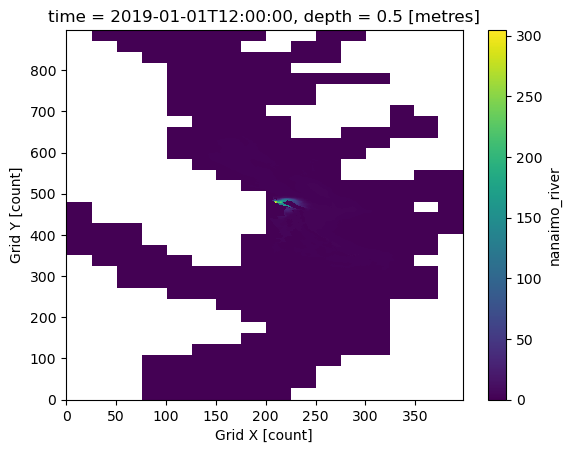

In [25]:
volds_test['nanaimo_river'][0][0].plot()